In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
!pip install ortools

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 48.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.7/133.7 kB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.2/309.2 kB 31.4 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
  Attempting uninstall: absl-py
    Found existing installation: absl-py 1.4.0
    Uninstalling absl-py-1.4.0:
      Successfully uninstalled absl-py-1.4.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires protobuf<5,>=3.20, but you have protobuf 5.27.0 which is incompatible.
google-ai-generativelanguage 0.6.4 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.19.5, but you have proto

In [4]:
import requests
from scipy.spatial import distance_matrix
import os
import base64
import cv2
import time
import re

In [5]:

def plot_mtsp_routes(points, routes_dict, routes_plot_filename):
    """Plot the routes and points for the mTSP problem."""
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

    # Plot points and routes
    plt.figure(figsize=(8, 8))

    # Plot all points in red except the depot
    for idx, (x, y) in enumerate(points):
        if idx == 0:
            plt.plot(x, y, 'ks', markersize=10)  # Depot
        else:
            plt.plot(x, y, 'ro')
        plt.text(x, y, str(idx), fontsize=12, ha='right')

    # Plot routes
    for route in routes_dict.values():
        route_points = [points[node] for node in route]
        route_points = np.array(route_points)
        color = colors.pop(0) if colors else 'k'  # Default to black if out of colors
        plt.plot(route_points[:, 0], route_points[:, 1], marker='o', color=color, linestyle='-', linewidth=2, markersize=6)

    plt.savefig(routes_plot_filename, dpi=300, bbox_inches='tight', pad_inches=0.1)
    #plt.show()
    plt.close()




In [6]:
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp
import numpy as np
import random
import json
import matplotlib.pyplot as plt

def create_data_model(num_locations, num_salesmen):
    """Stores the data for the problem."""
    data = {}
    data['locations'] = [(random.uniform(0, 5), random.uniform(0, 5)) for _ in range(num_locations)]
    data['num_locations'] = num_locations
    data['num_vehicles'] = num_salesmen
    data['depot'] = 0
    return data

def compute_euclidean_distance_matrix(locations):
    """Creates callback to return distance between points."""
    distances = np.zeros((len(locations), len(locations)))
    for from_node in range(len(locations)):
        for to_node in range(len(locations)):
            if from_node != to_node:
                distances[from_node][to_node] = np.linalg.norm(
                    np.array(locations[from_node]) - np.array(locations[to_node]))
    return distances

def print_solution(manager, routing, solution):
    """Prints solution on console."""
    total_distance = 0.0
    solution_data = {'routes': [], 'total_distance': 0.0}
    for vehicle_id in range(manager.GetNumberOfVehicles()):
        index = routing.Start(vehicle_id)
        route = []
        route_distance = 0.0
        while not routing.IsEnd(index):
            route.append(manager.IndexToNode(index))
            previous_index = index
            index = solution.Value(routing.NextVar(index))
            route_distance += routing.GetArcCostForVehicle(previous_index, index, vehicle_id) / 1000.0
        route.append(manager.IndexToNode(index))
        solution_data['routes'].append({
            'route': route,
            'distance': route_distance
        })
        total_distance += route_distance
    solution_data['total_distance'] = total_distance
    return solution_data

def save_solution_to_json(data, solution_data, filename='solution.json'):
    output_data = {
        'locations': data['locations'],
        'solution': solution_data
    }
    with open(filename, 'w') as f:
        json.dump(output_data, f, indent=4)
def plot_routes(locations, routes, filename):
    """Plot the routes on a 2D plot."""
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
    plt.figure(figsize=(8, 8))
    for route in routes:
        route_points = [locations[node] for node in route['route']]
        route_points = np.array(route_points)
        plt.plot(route_points[:, 0], route_points[:, 1], marker='o', color=colors.pop(0), linestyle='-', linewidth=2, markersize=6)

    # Plot depot with a different marker and color
    depot_x, depot_y = locations[0]
    plt.plot(depot_x, depot_y, 'ks', markersize=10)  # 'ks' stands for black square

    for idx, (x, y) in enumerate(locations):
        plt.text(x, y, str(idx), fontsize=12, ha='right')

    plt.savefig(filename, dpi=300, bbox_inches='tight', pad_inches=0.1)
    #plt.show()
    plt.close()
def plot_points(locations, filename):
    """Plot the data points on a 2D plot."""
    plt.figure(figsize=(8, 8))
    for idx, (x, y) in enumerate(locations):
        if idx == 0:
            plt.plot(x, y, 'ks', markersize=10)  # Plot depot with a different marker and color
        else:
            plt.plot(x, y, 'bo')
        plt.text(x, y, str(idx), fontsize=12, ha='right')

    plt.savefig(filename, dpi=300, bbox_inches='tight', pad_inches=0.1)
    #plt.show()
    plt.close()

def gen_mtsp(num_locations, num_salesmen,n,site):
    """Solve the mTSP problem."""
    data = create_data_model(num_locations, num_salesmen)

    # Create the routing index manager.
    manager = pywrapcp.RoutingIndexManager(data['num_locations'], data['num_vehicles'], data['depot'])

    # Create Routing Model.
    routing = pywrapcp.RoutingModel(manager)

    # Create and register a transit callback.
    distance_matrix = compute_euclidean_distance_matrix(data['locations'])
    def distance_callback(from_index, to_index):
        """Returns the distance between the two nodes."""
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return int(distance_matrix[from_node][to_node] * 1000)  # Convert to integer for OR-Tools

    transit_callback_index = routing.RegisterTransitCallback(distance_callback)

    # Define cost of each arc.
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

    # Add Distance constraint.
    dimension_name = 'Distance'
    routing.AddDimension(
        transit_callback_index,
        0,  # no slack
        300000,  # vehicle maximum travel distance
        True,  # start cumul to zero
        dimension_name)
    distance_dimension = routing.GetDimensionOrDie(dimension_name)
    distance_dimension.SetGlobalSpanCostCoefficient(100)

    # Setting first solution heuristic.
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.first_solution_strategy = routing_enums_pb2.FirstSolutionStrategy.SAVINGS
    search_parameters.local_search_metaheuristic = routing_enums_pb2.LocalSearchMetaheuristic.GUIDED_LOCAL_SEARCH
    search_parameters.time_limit.seconds = 120  # Increase the time limit for better solutions

    # Solve the problem.
    solution = routing.SolveWithParameters(search_parameters)

    # Print solution on console.
    if solution:
        solution_data = print_solution(manager, routing, solution)
        json_filename = '/content/drive/MyDrive/MTSP_GPT/solution.json'
        routes_plot_filename = f'/content/drive/MyDrive/MTSP_GPT/OR_routes_{n}_{site}.png'
        points_plot_filename = f'/content/drive/MyDrive/MTSP_GPT/points_{n}_{site}.png'

        save_solution_to_json(data, solution_data, json_filename)
        print(f"Solution saved to {json_filename}")

        # Plot and save the solution routes
        plot_routes(data['locations'], solution_data['routes'], routes_plot_filename)
        print(f"Routes plot saved to {routes_plot_filename}")

        # Plot and save the data points
        plot_points(data['locations'], points_plot_filename)
        print(f"Data points plot saved to {points_plot_filename}")
    return data['locations'], data, solution_data
# # Example usage
# num_locations = 20  # Number of locations (including the depot)
# num_salesmen = 3  # Number of salesmen
# locations = gen_mtsp(num_locations, num_salesmen)


In [7]:
def generate_prompt(num_salesmen):
    prompt = f"""
    Inspect the provided image and find routes for {num_salesmen} salesmen starting from the depot, which is marked with a black square. Ensure that:

    - All nodes are visited once by only one salesman.
    - Each salesman starts from the depot and returns to the depot.
    - Minimize intersections between the different routes and within the same route.
    - Each route should cover a cluster of points.
    - The routes should be as short as possible.

    Output the sequences for the routes in the following format:
    <<start>>
    """
    for i in range(1, num_salesmen + 1):
        prompt += f"Salesman{i}: Depot-Node1-Node2-...-Depot\n"
    prompt += "<<end>>\n\nDo not include any additional explanations or text. Use only the output format specified above."

    return prompt
def generate_prompt_2(num_salesmen):
    prompt = f"""
    Inspect the provided image and find routes for {num_salesmen} salesmen starting from the depot, which is marked with a black square. Ensure that:

    - All nodes are visited once by only one salesman.
    - Each salesman starts from the depot and returns to the depot.
    - Minimize intersections between the different routes and within the same route.
    - Each route should cover a cluster of points.
    - The routes should be as short as possible.
    - Aim to improve upon the current routes shown in the image by further reducing intersections and optimizing the travel distance.

    Output the sequences for the routes in the following format:
    <<start>>
    """
    for i in range(1, num_salesmen + 1):
        prompt += f"Salesman{i}: Depot-Node1-Node2-...-Depot\n"
    prompt += "<<end>>\n\nDo not include any additional explanations or text. Use only the output format specified above."

    return prompt


In [8]:
import re
import json

def extract_and_save_routes(model_completion):
    """
    Extract routes from model completion and save them to a JSON file.

    Args:
        model_completion (dict): The model completion data.
        json_filename (str): The path to the JSON file where the routes will be saved.

    Returns:
        dict: The extracted routes.
    """
    # Extract the routes
    content = model_completion['choices'][0]['message']['content']
    routes_str = re.search(r'<<start>>(.*?)<<end>>', content, re.DOTALL).group(1).strip()

    # Replace "Depot" with "0" and split into routes
    routes = routes_str.replace('Depot', '0').split('\n')

    # Create a dictionary to store the routes
    routes_dict = {}
    for route in routes:
        salesman, path = route.split(':')
        path = [int(node) for node in path.strip().split('-')]
        routes_dict[salesman.strip()] = path



    # Example output of the routes_dict
    #print(json.dumps(routes_dict, indent=4))

    return routes_dict





In [9]:
# Function to encode the image to base64
def encode_image(image_path):
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode('utf-8')

In [10]:
# Iterate over the filenames and send each to the OpenAI API
#def query_gpt(prompt, api_key,n,ite):
def query_gpt(prompt, api_key,image_path,TM):

    base64_image = encode_image(image_path)




    url = "https://api.openai.com/v1/chat/completions"
    headers = {
      "Content-Type": "application/json",
      "Authorization": f"Bearer {api_key}"
    }

    payload = {
      "model": "gpt-4o",
      "messages": [
        {
          "role": "user",
          "content": [
            {
              "type": "text",
              "text":prompt
            },
            {
              "type": "image_url",
              "image_url": {
                "url": f"data:image/jpeg;base64,{base64_image}"
              }
            }

          ]
        }
      ],
      #"max_tokens": 3000,
      #  "temperature": 0.0,
        "max_tokens": 4000,
        "temperature": TM,
        "n": 1
    }
    response = requests.post(url, headers=headers, json=payload)
    return response.json()

In [11]:
# api_key = "api-key"
# # def main():
# #     # Initial empty dictionary to store results
# RES = {}


# # Iterate over n and site
# for n in range(10,40,5):
#     for site in range(30):
#         num_locations = n  # Number of locations (including the depot)
#         num_salesmen = 2  # Number of salesmen, can also vary with site or n if needed

#         # Generate MTSP data and get points and data dictionary
#         points, data,solution_data = gen_mtsp(num_locations, num_salesmen,n,site)

#         # Store the problem data under a unique key for each n and site
#         RES[f'problem_{n}_{site}'] = data
#         RES[f'solution_data_{n}_{site}'] =solution_data

#         # Generate a problem statement for GPT
#         problem_statement = generate_prompt(num_salesmen)

#         # Querying GPT (simulated here as a function call)
#         folder_path = '/content/drive/My Drive/MTSP_GPT'  # Change this to your desired file path
#         # if not os.path.exists(folder_path):
#         #     os.makedirs(folder_path)
#         image_path = os.path.join(folder_path, f'points_{n}_{site}.png')
#         # Getting the base64 string
#         #image_path = os.path.join(folder_path, f'points.png')
#         result = query_gpt(problem_statement, api_key,image_path,0.0)


#         # Extract and save routes
#         routes_dict = extract_and_save_routes(result)

#         # Store routes data under a unique key for each n and site
#         RES[f'routes_{n}_{site}'] = routes_dict

#         # Plot MTSP routes (Assuming a function to plot given points and routes exists)
#         routes_plot_filename= f'/content/drive/MyDrive/MTSP_GPT/routes_{n}_{site}_0.png'
#         plot_mtsp_routes(points, routes_dict,routes_plot_filename)

#         # Save the entire RES dictionary to a JSON file after the loops complete
#         final_json_filename = '/content/drive/MyDrive/MTSP_GPT/final_results.json'
#         with open(final_json_filename, 'w') as f:
#             json.dump(RES, f, indent=4)
#         for tr in range(10):
#                     # Generate a problem statement for GPT
#             problem_statement2 = generate_prompt_2(num_salesmen)


#             image_path=f'/content/drive/MyDrive/MTSP_GPT/routes_{n}_{site}_{tr}.png'
#             result = query_gpt(problem_statement2, api_key,image_path,0.7)
#             time.sleep(30)



#             # Extract and save routes
#             routes_dict = extract_and_save_routes(result)

#             # Store routes data under a unique key for each n and site
#             RES[f'path_{n}_{site}_{tr}'] = routes_dict

#             # Plot MTSP routes (Assuming a function to plot given points and routes exists)
#             routes_plot_filename= f'/content/drive/MyDrive/MTSP_GPT/routes_{n}_{site}_{tr+1}.png'
#             plot_mtsp_routes(points, routes_dict,routes_plot_filename)
#             # Save the entire RES dictionary to a JSON file after the loops complete
#             final_json_filename = '/content/drive/MyDrive/MTSP_GPT/final_results.json'
#             with open(final_json_filename, 'w') as f:
#                 json.dump(RES, f, indent=4)

# print("All results saved to JSON file.")

# # # Entry point of the script
# # if __name__ == "__main__":
# #     main()



Solution saved to /content/drive/MyDrive/MTSP_GPT/solution.json
Routes plot saved to /content/drive/MyDrive/MTSP_GPT/OR_routes_10_0.png
Data points plot saved to /content/drive/MyDrive/MTSP_GPT/points_10_0.png
Solution saved to /content/drive/MyDrive/MTSP_GPT/solution.json
Routes plot saved to /content/drive/MyDrive/MTSP_GPT/OR_routes_10_1.png
Data points plot saved to /content/drive/MyDrive/MTSP_GPT/points_10_1.png
Solution saved to /content/drive/MyDrive/MTSP_GPT/solution.json
Routes plot saved to /content/drive/MyDrive/MTSP_GPT/OR_routes_10_2.png
Data points plot saved to /content/drive/MyDrive/MTSP_GPT/points_10_2.png
Solution saved to /content/drive/MyDrive/MTSP_GPT/solution.json
Routes plot saved to /content/drive/MyDrive/MTSP_GPT/OR_routes_10_3.png
Data points plot saved to /content/drive/MyDrive/MTSP_GPT/points_10_3.png
Solution saved to /content/drive/MyDrive/MTSP_GPT/solution.json
Routes plot saved to /content/drive/MyDrive/MTSP_GPT/OR_routes_10_4.png
Data points plot saved t

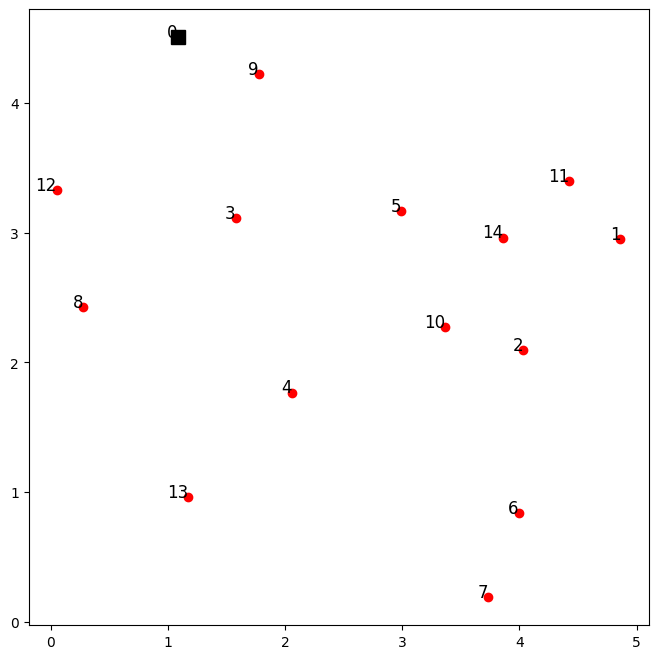

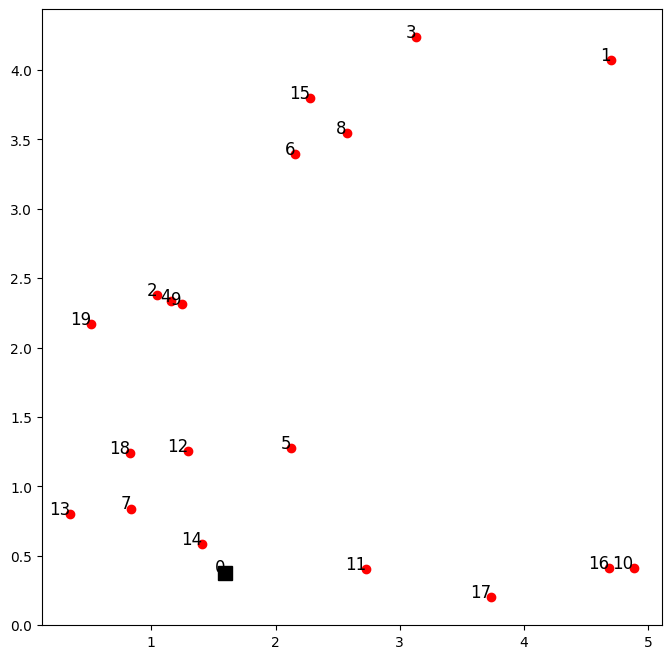

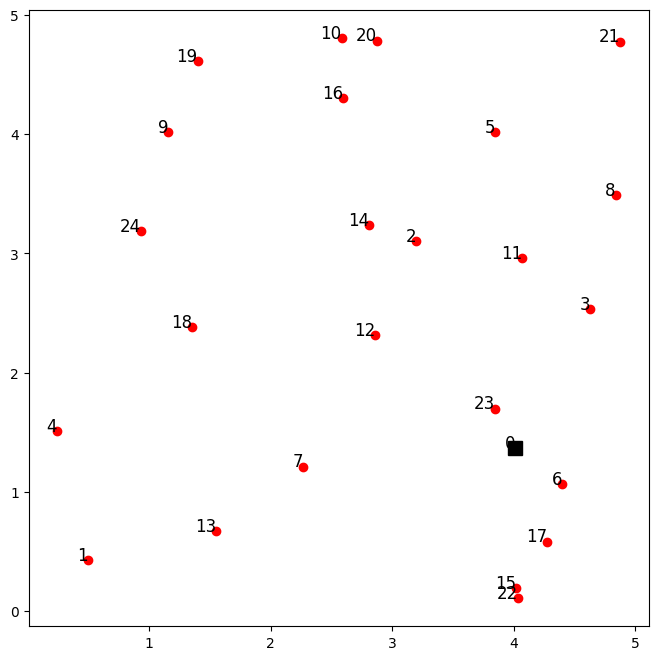

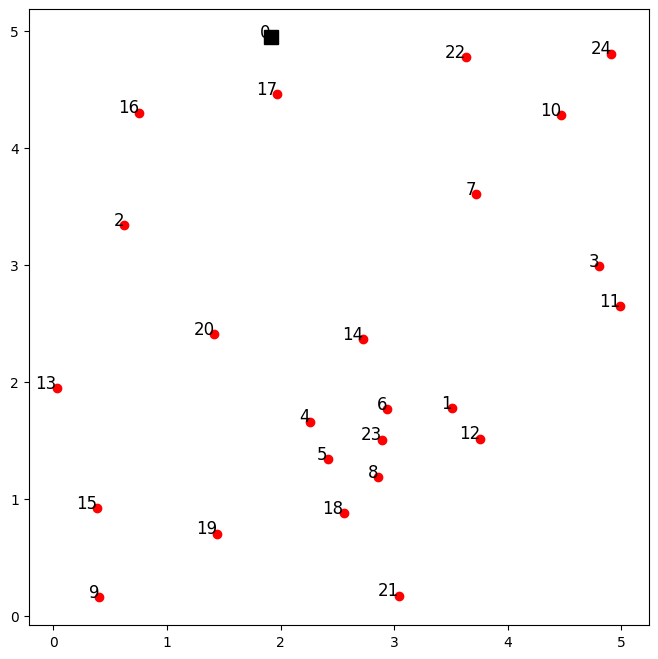

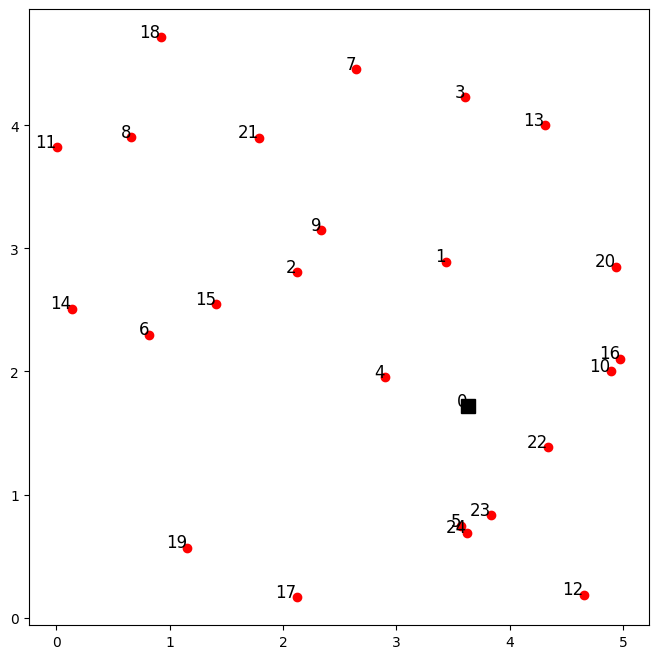

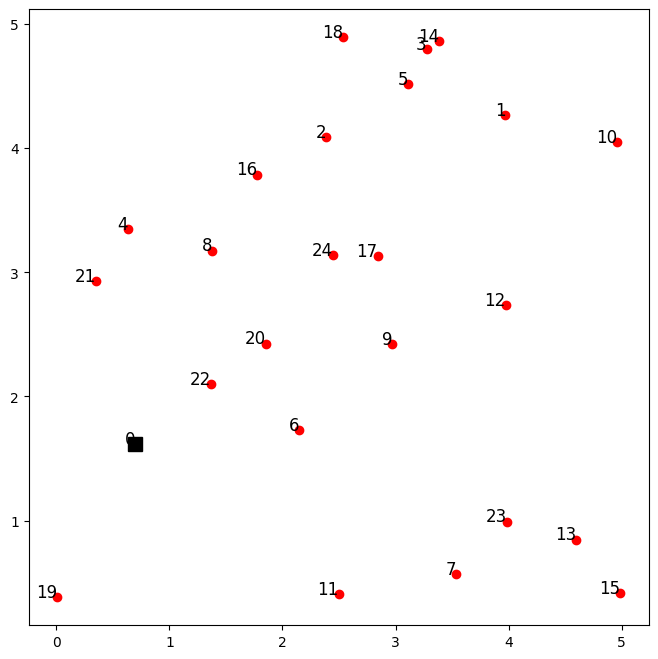

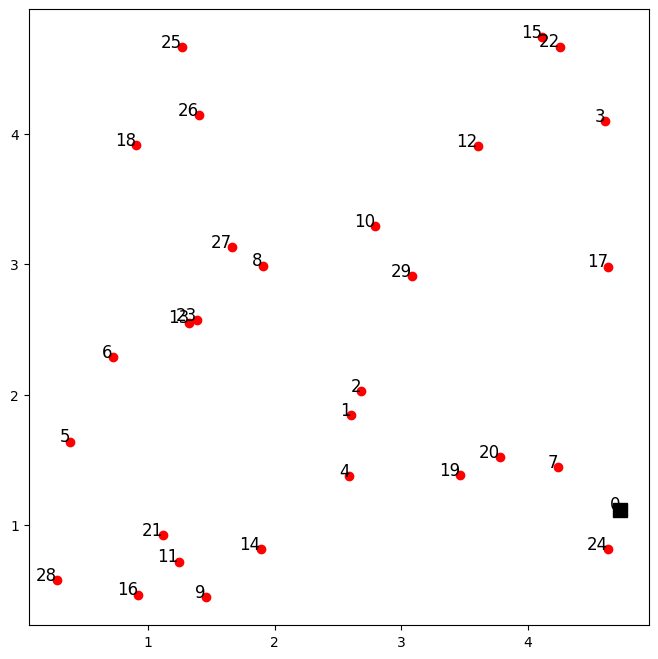

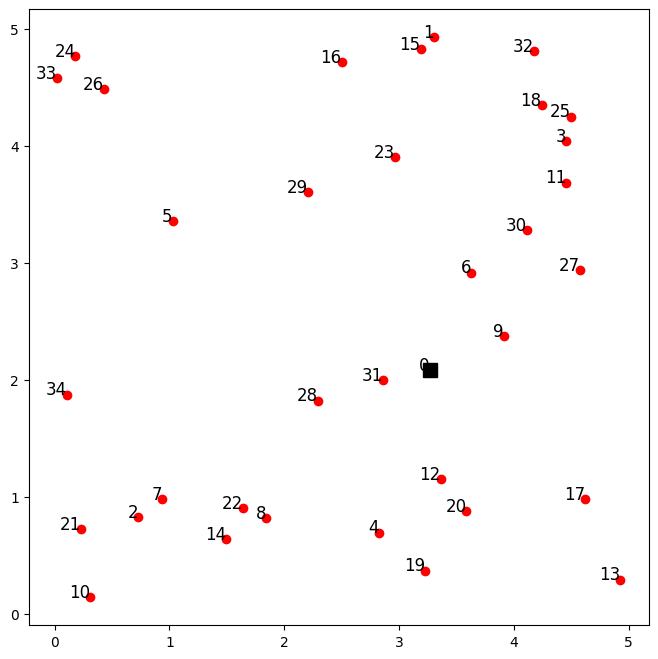

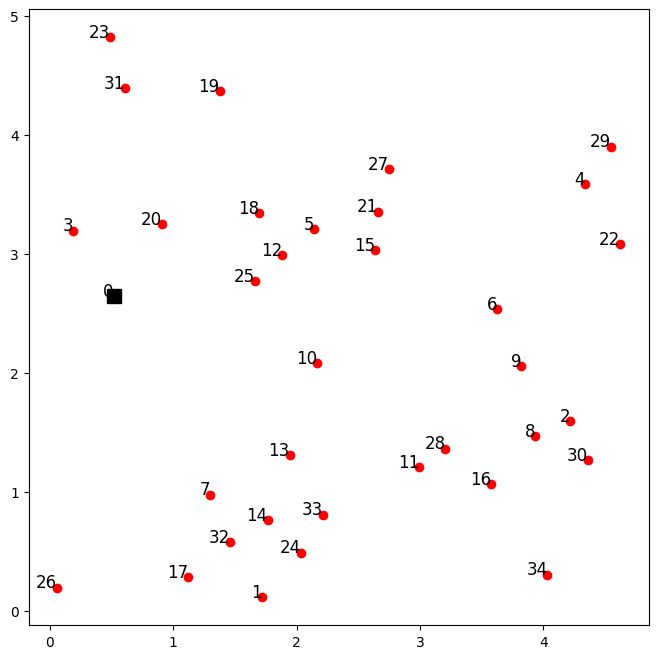

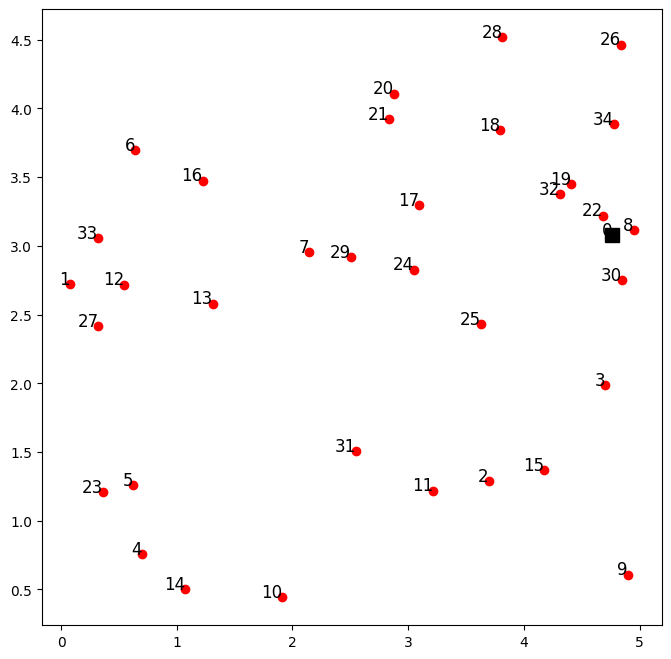

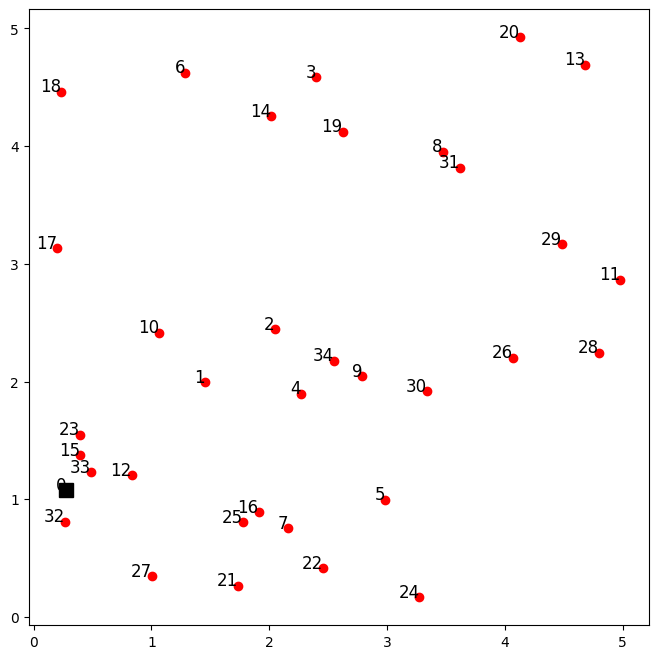

In [12]:
import os
import json
import time

# Add your Open ai API key here
api_key = "API_KEY"
RES = {}

# Iterate over n and site
for n in range(10, 40, 5):
    for site in range(30):
        try:
            num_locations = n  # Number of locations (including the depot)
            num_salesmen = 1  # Number of salesmen, can also vary with site or n if needed

            # Generate MTSP data and get points and data dictionary
            points, data, solution_data = gen_mtsp(num_locations, num_salesmen, n, site)

            # Store the problem data under a unique key for each n and site
            RES[f'problem_{n}_{site}'] = data
            RES[f'solution_data_{n}_{site}'] = solution_data

            # Generate a problem statement for GPT
            problem_statement = generate_prompt(num_salesmen)

            # Querying GPT (simulated here as a function call)
            folder_path = '/content/drive/My Drive/MTSP_GPT'  # Change this to your desired file path
            image_path = os.path.join(folder_path, f'points_{n}_{site}.png')
            result = query_gpt(problem_statement, api_key, image_path, 0.0)

            # Extract and save routes
            routes_dict = extract_and_save_routes(result)

            # Store routes data under a unique key for each n and site
            RES[f'routes_{n}_{site}'] = routes_dict

            # Plot MTSP routes (Assuming a function to plot given points and routes exists)
            routes_plot_filename = f'/content/drive/MyDrive/MTSP_GPT/routes_{n}_{site}_0.png'
            plot_mtsp_routes(points, routes_dict, routes_plot_filename)

            # Save the entire RES dictionary to a JSON file after the loops complete
            final_json_filename = '/content/drive/MyDrive/MTSP_GPT/final_results.json'
            with open(final_json_filename, 'w') as f:
                json.dump(RES, f, indent=4)

            for tr in range(10):
                try:
                    # Generate a problem statement for GPT
                    problem_statement2 = generate_prompt_2(num_salesmen)

                    image_path = f'/content/drive/MyDrive/MTSP_GPT/routes_{n}_{site}_{tr}.png'
                    result = query_gpt(problem_statement2, api_key, image_path, 0.7)
                    time.sleep(30)

                    # Extract and save routes
                    routes_dict = extract_and_save_routes(result)

                    # Store routes data under a unique key for each n and site
                    RES[f'path_{n}_{site}_{tr}'] = routes_dict

                    # Plot MTSP routes (Assuming a function to plot given points and routes exists)
                    routes_plot_filename = f'/content/drive/MyDrive/MTSP_GPT/routes_{n}_{site}_{tr+1}.png'
                    plot_mtsp_routes(points, routes_dict, routes_plot_filename)

                    # Save the entire RES dictionary to a JSON file after the loops complete
                    final_json_filename = '/content/drive/MyDrive/MTSP_GPT/final_results.json'
                    with open(final_json_filename, 'w') as f:
                        json.dump(RES, f, indent=4)
                except Exception as e:
                    print(f"An error occurred in the inner loop for n={n}, site={site}, tr={tr}: {e}")
                    continue

        except Exception as e:
            print(f"An error occurred in the outer loop for n={n}, site={site}: {e}")
            continue

print("All results saved to JSON file.")
